In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/pso_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:

class Particle:
    swarm_best_coloring = None
    swarm_best_value = None
    
    def __init__(self, graph, num_colors, c_i, c_p, c_s):
        self.c_i = c_i
        self.c_p = c_p
        self.c_s = c_s
        
        self.graph = graph
        self.num_colors = num_colors
        self.colors = np.random.randint(0, num_colors, len(graph.edges()))
        self.velocity = np.random.uniform(-1, 1, len(graph.edges()))
        
        self.personal_best_coloring = self.colors.copy()
        self.value = self.calculate_conflicts()
        self.personal_best_value = self.value
        if Particle.swarm_best_value is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_value = self.value
            Particle.swarm_best_coloring = self.colors.copy()
            
    def calculate_conflicts(self):
        conflicts = 0
        edge_color = {edge: self.colors[i] for i, edge in enumerate(self.graph.edges())}
        for edge in self.graph.edges():
            u, v = edge
            u_edges = neighbor_edges_of_node(self.graph, u)
            v_edges = neighbor_edges_of_node(self.graph, v)
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    conflicts += 1
            
            for j in range(len(v_edges)):
                if edge_color[v_edges[j]] == edge_color[edge]:
                    conflicts += 1
        return conflicts // 2
    
    def update_colors(self):
        self.colors = np.clip(self.colors + self.velocity, 0, self.num_colors - 1)
        self.value = self.calculate_conflicts()
        if self.value < self.personal_best_value and is_valid_coloring(self.graph, self.colors):
            self.personal_best_value = self.value
            self.personal_best_coloring = self.colors.copy()
            if self.value < Particle.swarm_best_value:
                Particle.swarm_best_value = self.value
                Particle.swarm_best_coloring = self.colors.copy()
        else:
            return -100
    
    def update_velocity(self, iteration):
        cognitive_velocity = self.personal_best_coloring - self.colors
        social_velocity = Particle.swarm_best_coloring - self.colors
        r_p = np.random.random(len(cognitive_velocity))
        r_s = np.random.random(len(social_velocity))
        self.velocity = (self.c_i / iteration) * self.velocity + \
                        self.c_p * r_p * cognitive_velocity + \
                        self.c_s * r_s * social_velocity

In [9]:
def pso(graph, swarm_size, num_iters, c_i, c_p, c_s):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_nodes  # Inicijalno postavljamo broj boja na broj čvorova
    swarm = [Particle(graph, num_colors, c_i, c_p, c_s) for _ in range(swarm_size)]
    for i in range(num_iters):
        for p in swarm:
            p.update_velocity(i + 1)  # Povećavamo faktor c_i kako se iteracije povećavaju
            p.update_colors()
        # Ažuriramo broj boja ako smo pronašli bolje bojanje
        if Particle.swarm_best_value < num_colors:
            num_colors = Particle.swarm_best_value
            for p in swarm:
                p.num_colors = num_colors
    return Particle.swarm_best_coloring, Particle.swarm_best_value, num_colors



In [12]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    swarm_size = 10  
    num_iters = 100  
    c_i = 0.5  
    c_p = 1 
    c_s = 1  

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, best_value, num_colors = pso(graph, swarm_size, num_iters, c_i, c_p, c_s)
            end_time = time.time()

            coloring_result = best_individual

            write_output(graph, file, coloring_result, num_colors, start_time, end_time) 
            Particle.swarm_best_coloring = None
            Particle.swarm_best_value = None

Running test graph_3_edges.txt...
[2 0 1]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 0


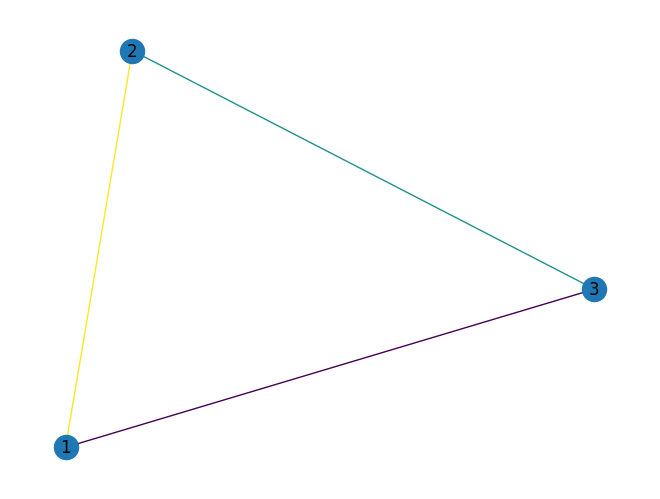

Time taken: 0.055086374282836914 seconds

Running test graph_5_edges.txt...
[0.47389756 0.24697371 0.6001884  1.01472018 1.79815083]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


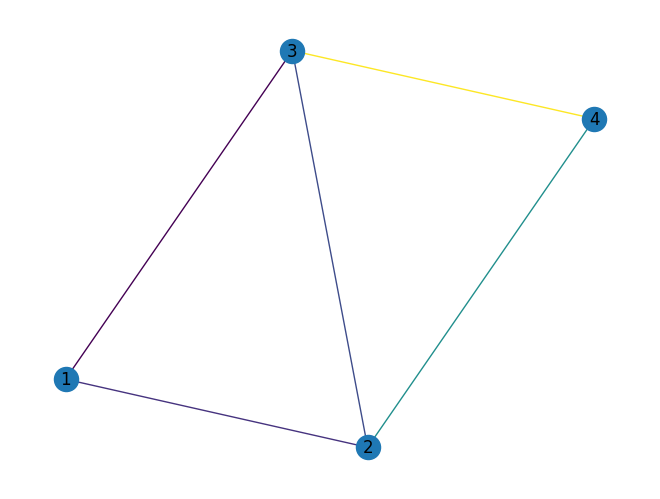

Time taken: 0.05784344673156738 seconds

Running test graph_5_edges_2.txt...
[0.         1.08462071 0.46705615 1.36449509 2.27369945]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


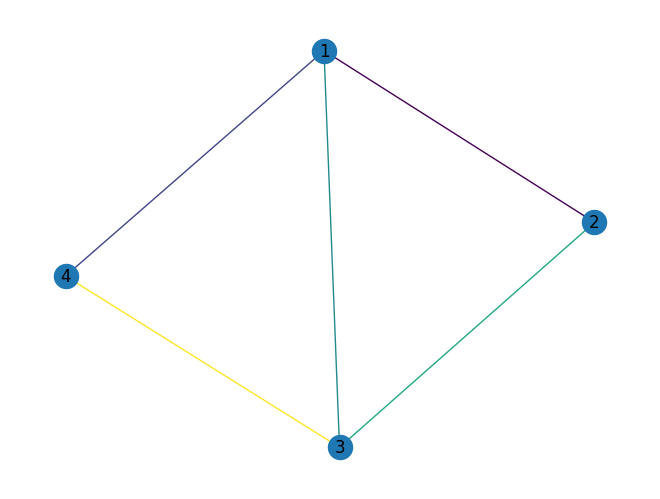

Time taken: 0.05940365791320801 seconds

Running test graph_6_edges.txt...
[5 2 3 1 0 4]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 0


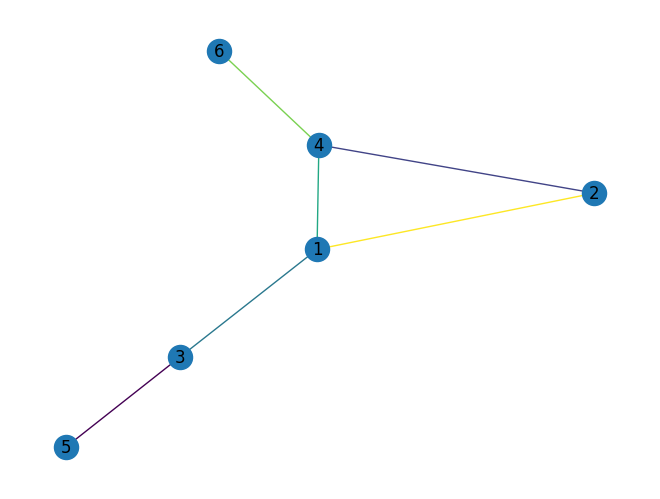

Time taken: 0.07236313819885254 seconds

Running test graph_7_edges.txt...
[3 1 2 0 2 0 1]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 0


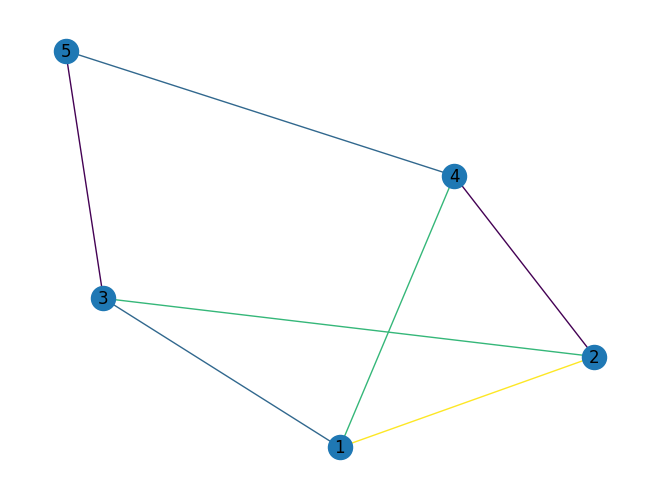

Time taken: 0.07897281646728516 seconds

Running test graph_7_edges_2.txt...
[1.18189555 0.79008163 1.38395002 3.06877084 3.69139674 3.16725323
 1.87168235]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


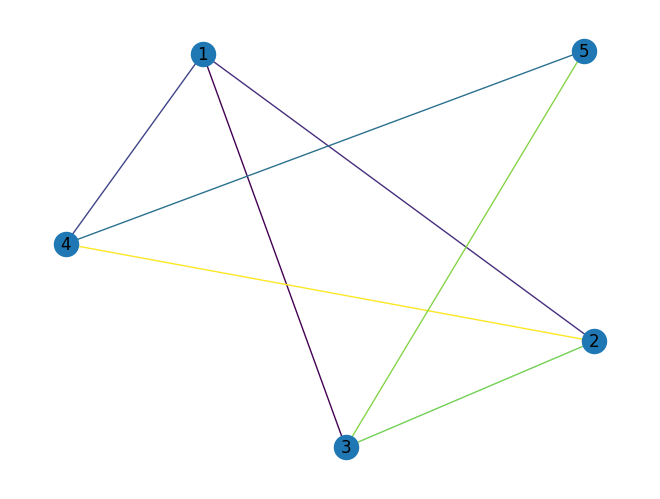

Time taken: 0.07452249526977539 seconds

Running test graph_7_edges_3.txt...
[7 6 3 4 0 5 2]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


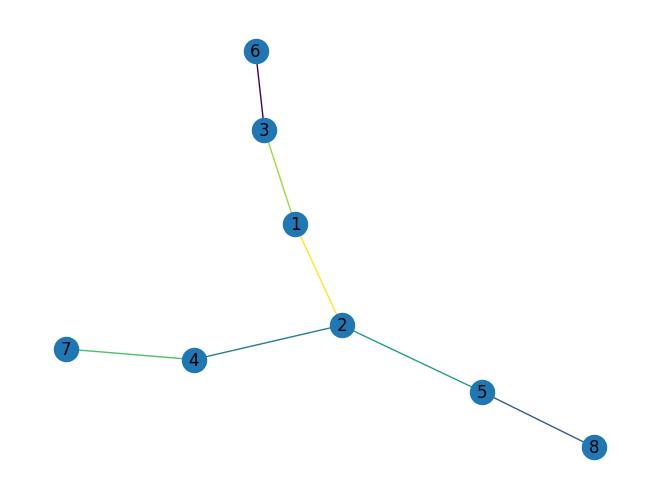

Time taken: 0.08881521224975586 seconds

Running test graph_8_edges.txt...
[0 5 7 5 0 2 7 8]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 0


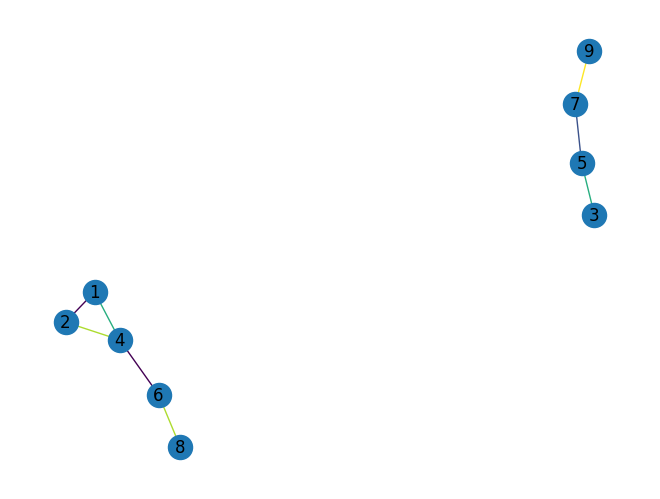

Time taken: 0.09752631187438965 seconds

Running test graph_9_edges.txt...
[1.05777277 2.58272171 4.65463081 3.66414029 2.73723158 3.01533817
 3.36553317 2.07879681 3.56930805]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 0


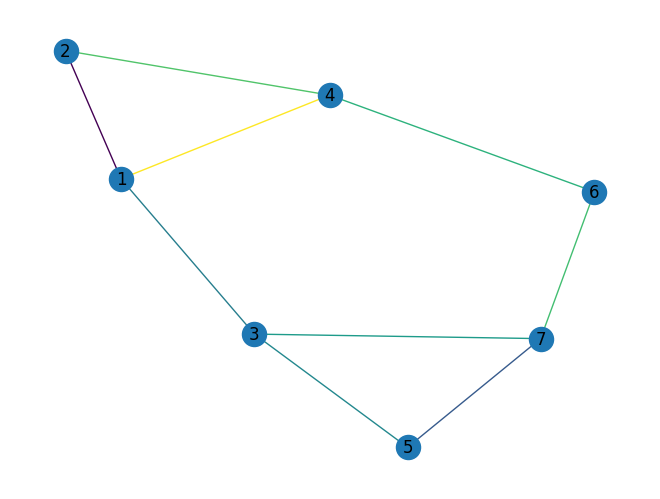

Time taken: 0.10423922538757324 seconds

Running test graph_9_edges_2.txt...
[8 6 9 4 5 1 9 6 9]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 0


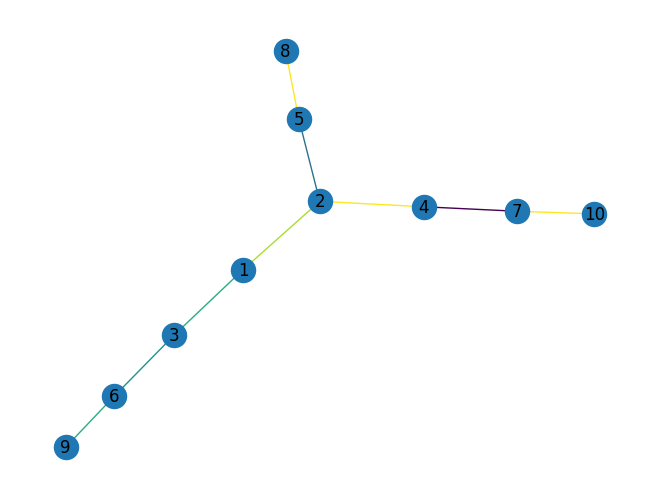

Time taken: 0.10693645477294922 seconds

Running test graph_10_edges.txt...
[ 1  2  2  6  1  8 10  0  5  6]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


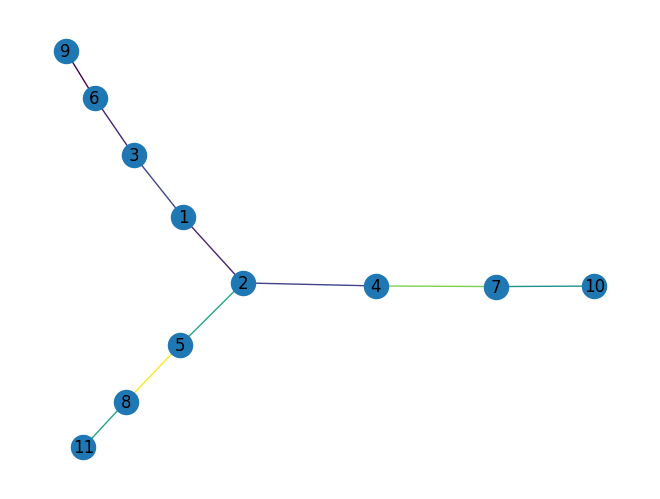

Time taken: 0.1268472671508789 seconds

Running test graph_10_edges_2.txt...
[4.60765618 0.89692539 2.18129393 1.60587802 3.40241167 1.03684617
 3.86667673 4.51426561 1.34044644 1.36515986]
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 0


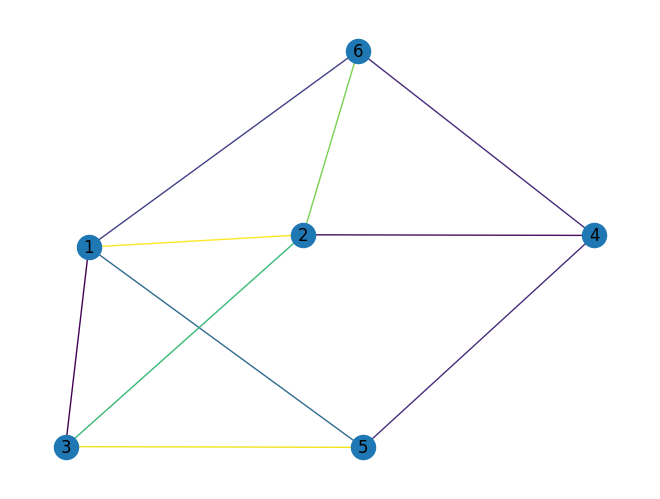

Time taken: 0.10827970504760742 seconds

Running test graph_10_edges_3.txt...
[0 6 8 3 4 2 2 8 5 2]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 0


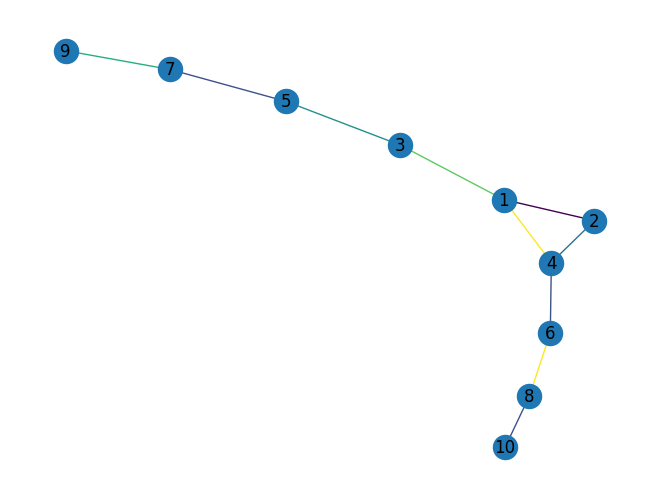

In [ ]:
run_tests('./tests')